# Computing a sparse solution of a set of linear inequalities

A derivative work by Judson Wilson, 5/11/2014.<br>
Adapted from the CVX example of the same name, by Almir Mutapcic, 2/28/2006.

Topic References:

* Section 6.2, Boyd & Vandenberghe "Convex Optimization" <br>
* "Just relax: Convex programming methods for subset selection and sparse approximation" by J. A. Tropp


## Introduction


We consider a set of linear inequalities 
$Ax \preceq b$ 
which are feasible. We apply two heuristics to find a sparse point $x$ that satisfies these inequalities.

The (standard) $\ell_1$-norm heuristic for finding a sparse solution is:
    \begin{array}{ll}
    \mbox{minimize}   &  \|x\|_1 \\
    \mbox{subject to} & Ax \preceq b.
    \end{array}

The log-based heuristic is an iterative method for finding
a sparse solution, by finding a local optimal point for the problem:
    \begin{array}{ll}
    \mbox{minimize}   &  \sum_i \log \left( \delta + \left|x_i\right| \right) \\
    \mbox{subject to} & Ax \preceq b,
    \end{array}
where $\delta$ is a small threshold value (which determines if a value is close to zero).
We cannot solve this problem since it is a minimization of a concave
function and thus it is not a convex problem. However, we can apply
a heuristic in which we linearize the objective, solve, and re-iterate.
This becomes a weighted $\ell_1$-norm heuristic:
    \begin{array}{ll}
    \mbox{minimize}   &  \sum_i W_i \left|x_i\right| \\
    \mbox{subject to} & Ax \preceq b,
    \end{array}
which in each iteration re-adjusts the weights $W_i$ based on the rule:
    $$W_i = 1/(\delta + \left|x_i\right|),$$
where $\delta$ is a small threshold value.

This algorithm is described in papers:

* "An affine scaling methodology for best basis selection"<br>
  by B. D. Rao and K. Kreutz-Delgado
* "Portfolio optimization with linear and fixed transaction costs"<br>
  by M. S. Lobo, M. Fazel, and S. Boyd

## Generate problem data

In [1]:
import cvxpy as cp
import numpy as np

# Fix random number generator so we can repeat the experiment.
np.random.seed(1)

# The threshold value below which we consider an element to be zero.
delta = 1e-8

# Problem dimensions (m inequalities in n-dimensional space).
m = 100
n = 50

# Construct a feasible set of inequalities.
# (This system is feasible for the x0 point.)
A  = np.random.randn(m, n)
x0 = np.random.randn(n)
b  = A.dot(x0) + np.random.random(m)

## $\ell_1$-norm heuristic

In [2]:
# Create variable.
x_l1 = cp.Variable(shape=n)

# Create constraint.
constraints = [A*x_l1 <= b]

# Form objective.
obj = cp.Minimize(cp.norm(x_l1, 1))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()
print("status: {}".format(prob.status))

# Number of nonzero elements in the solution (its cardinality or diversity).
nnz_l1 = (np.absolute(x_l1.value) > delta).sum()
print('Found a feasible x in R^{} that has {} nonzeros.'.format(n, nnz_l1))
print("optimal objective value: {}".format(obj.value))

status: optimal
Found a feasible x in R^50 that has 40 nonzeros.
optimal objective value: 28.582394099513873


## Iterative log heuristic

In [3]:
# Do 15 iterations, allocate variable to hold number of non-zeros
# (cardinality of x) for each run.
NUM_RUNS = 15
nnzs_log = np.array(())

# Store W as a positive parameter for simple modification of the problem.
W = cp.Parameter(shape=n, nonneg=True); 
x_log = cp.Variable(shape=n)

# Initial weights.
W.value = np.ones(n);

# Setup the problem.
obj = cp.Minimize( W.T*cp.abs(x_log) ) # sum of elementwise product
constraints = [A*x_log <= b]
prob = cp.Problem(obj, constraints)

# Do the iterations of the problem, solving and updating W.
for k in range(1, NUM_RUNS+1):
    # Solve problem.
    # The ECOS solver has known numerical issues with this problem
    # so force a different solver.
    prob.solve(solver=cp.CVXOPT)
    
    # Check for error.
    if prob.status != cp.OPTIMAL:
        raise Exception("Solver did not converge!")

    # Display new number of nonzeros in the solution vector.
    nnz = (np.absolute(x_log.value) > delta).sum()
    nnzs_log = np.append(nnzs_log, nnz);
    print('Iteration {}: Found a feasible x in R^{}'
          ' with {} nonzeros...'.format(k, n, nnz))

    # Adjust the weights elementwise and re-iterate
    W.value = np.ones(n)/(delta*np.ones(n) + np.absolute(x_log.value))

Iteration 1: Found a feasible x in R^50 with 48 nonzeros...
Iteration 2: Found a feasible x in R^50 with 36 nonzeros...
Iteration 3: Found a feasible x in R^50 with 33 nonzeros...
Iteration 4: Found a feasible x in R^50 with 33 nonzeros...
Iteration 5: Found a feasible x in R^50 with 33 nonzeros...
Iteration 6: Found a feasible x in R^50 with 33 nonzeros...
Iteration 7: Found a feasible x in R^50 with 33 nonzeros...
Iteration 8: Found a feasible x in R^50 with 33 nonzeros...
Iteration 9: Found a feasible x in R^50 with 33 nonzeros...
Iteration 10: Found a feasible x in R^50 with 33 nonzeros...
Iteration 11: Found a feasible x in R^50 with 33 nonzeros...
Iteration 12: Found a feasible x in R^50 with 33 nonzeros...
Iteration 13: Found a feasible x in R^50 with 33 nonzeros...
Iteration 14: Found a feasible x in R^50 with 33 nonzeros...
Iteration 15: Found a feasible x in R^50 with 33 nonzeros...


## Result plots

The following code plots the result of the $\ell_1$-norm heuristic, as well as the result for each iteration of the log heuristic.

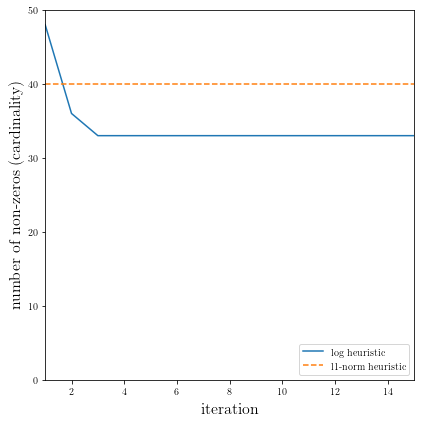

In [4]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6,6))

# Plot the two data series.
plt.plot(range(1,1+NUM_RUNS), nnzs_log, label='log heuristic')
plt.plot((1, NUM_RUNS), (nnz_l1, nnz_l1), linestyle='--', label='l1-norm heuristic')

# Format and show plot.
plt.xlabel('iteration', fontsize=16)
plt.ylabel('number of non-zeros (cardinality)', fontsize=16)
plt.ylim(0,n)
plt.xlim(1,NUM_RUNS)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()